# C3강현석_빅데이터분석(1) 1일차

## 다중선형 회귀분석 실습

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

matplotlib.rc("font",family = "NanumGothic")
matplotlib.rc("axes",unicode_minus = False)

df_raw = pd.read_csv("체질검사.csv", encoding = 'euc-kr')
df_raw.head()


,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER
0,35.2,46,363.15 lb,72.25 inch,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,남성
1,11.8,27,168 lb,71.25 inch,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,남성
2,22.2,69,177.75 lb,68.5 inch,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,남성
3,10.6,57,147.75 lb,65.75 inch,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,여성
4,47.5,51,219 lb,64 inch,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,여성


In [2]:
df_raw.isnull().sum()

FAT        0
AGE        0
WEIGHT     0
HEIGHT     0
NECK       0
CHEST      0
ABDOMEN    0
HIP        0
THIGH      0
KNEE       0
ANKLE      0
BICEPS     0
FOREARM    0
WRIST      0
GENDER     0
dtype: int64

WEIGHT와 HEIGHT의 단위 제거

In [3]:
df_raw[['WEIGHT','WEIGHT_UNIT']] = df_raw["WEIGHT"].str.split(expand=True)
df_raw[['HEIGHT','HEIGHT_UNIT']] = df_raw["HEIGHT"].str.split(expand=True)
df_raw["WEIGHT"] = df_raw["WEIGHT"].astype('float64')
df_raw["HEIGHT"] = df_raw["HEIGHT"].astype('float64')

df_raw = df_raw.drop(['WEIGHT_UNIT','HEIGHT_UNIT'],axis= 1)

df_raw_dummy = pd.get_dummies(df_raw, drop_first = True)
df_raw_dummy.head()


,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER_여성
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,0
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,0
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,0
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,1
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,1


파생변수 BMI 생성

In [4]:
df_raw_dummy["BMI"] = (df_raw_dummy["WEIGHT"] / ((df_raw_dummy["HEIGHT"]/100) ** 2)).round(1)
df_raw_dummy.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER_여성,BMI
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,0,695.7
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,0,330.9
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,0,378.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,1,341.8
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,1,534.7


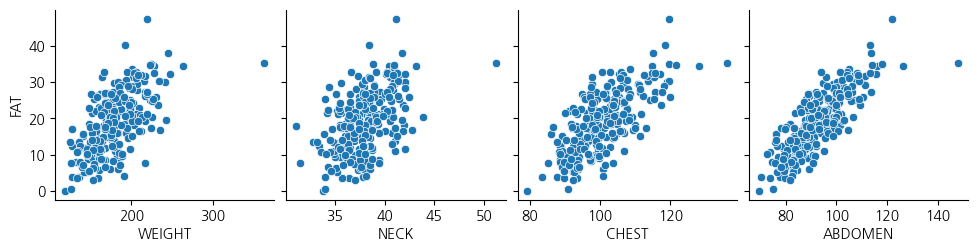

In [5]:
sns.pairplot(df_raw_dummy, y_vars="FAT",x_vars=["WEIGHT","NECK","CHEST","ABDOMEN"])

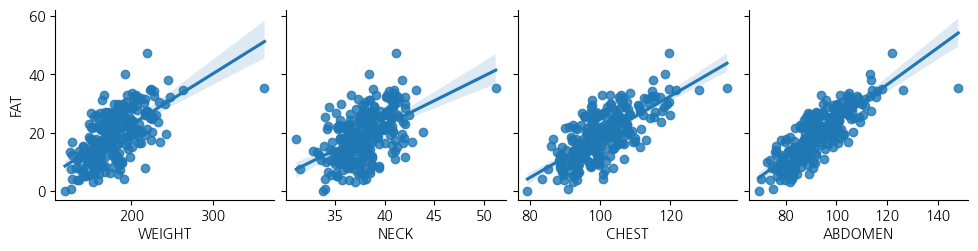

In [6]:
sns.pairplot(df_raw_dummy, y_vars="FAT",x_vars=["WEIGHT","NECK","CHEST","ABDOMEN"],kind="reg")

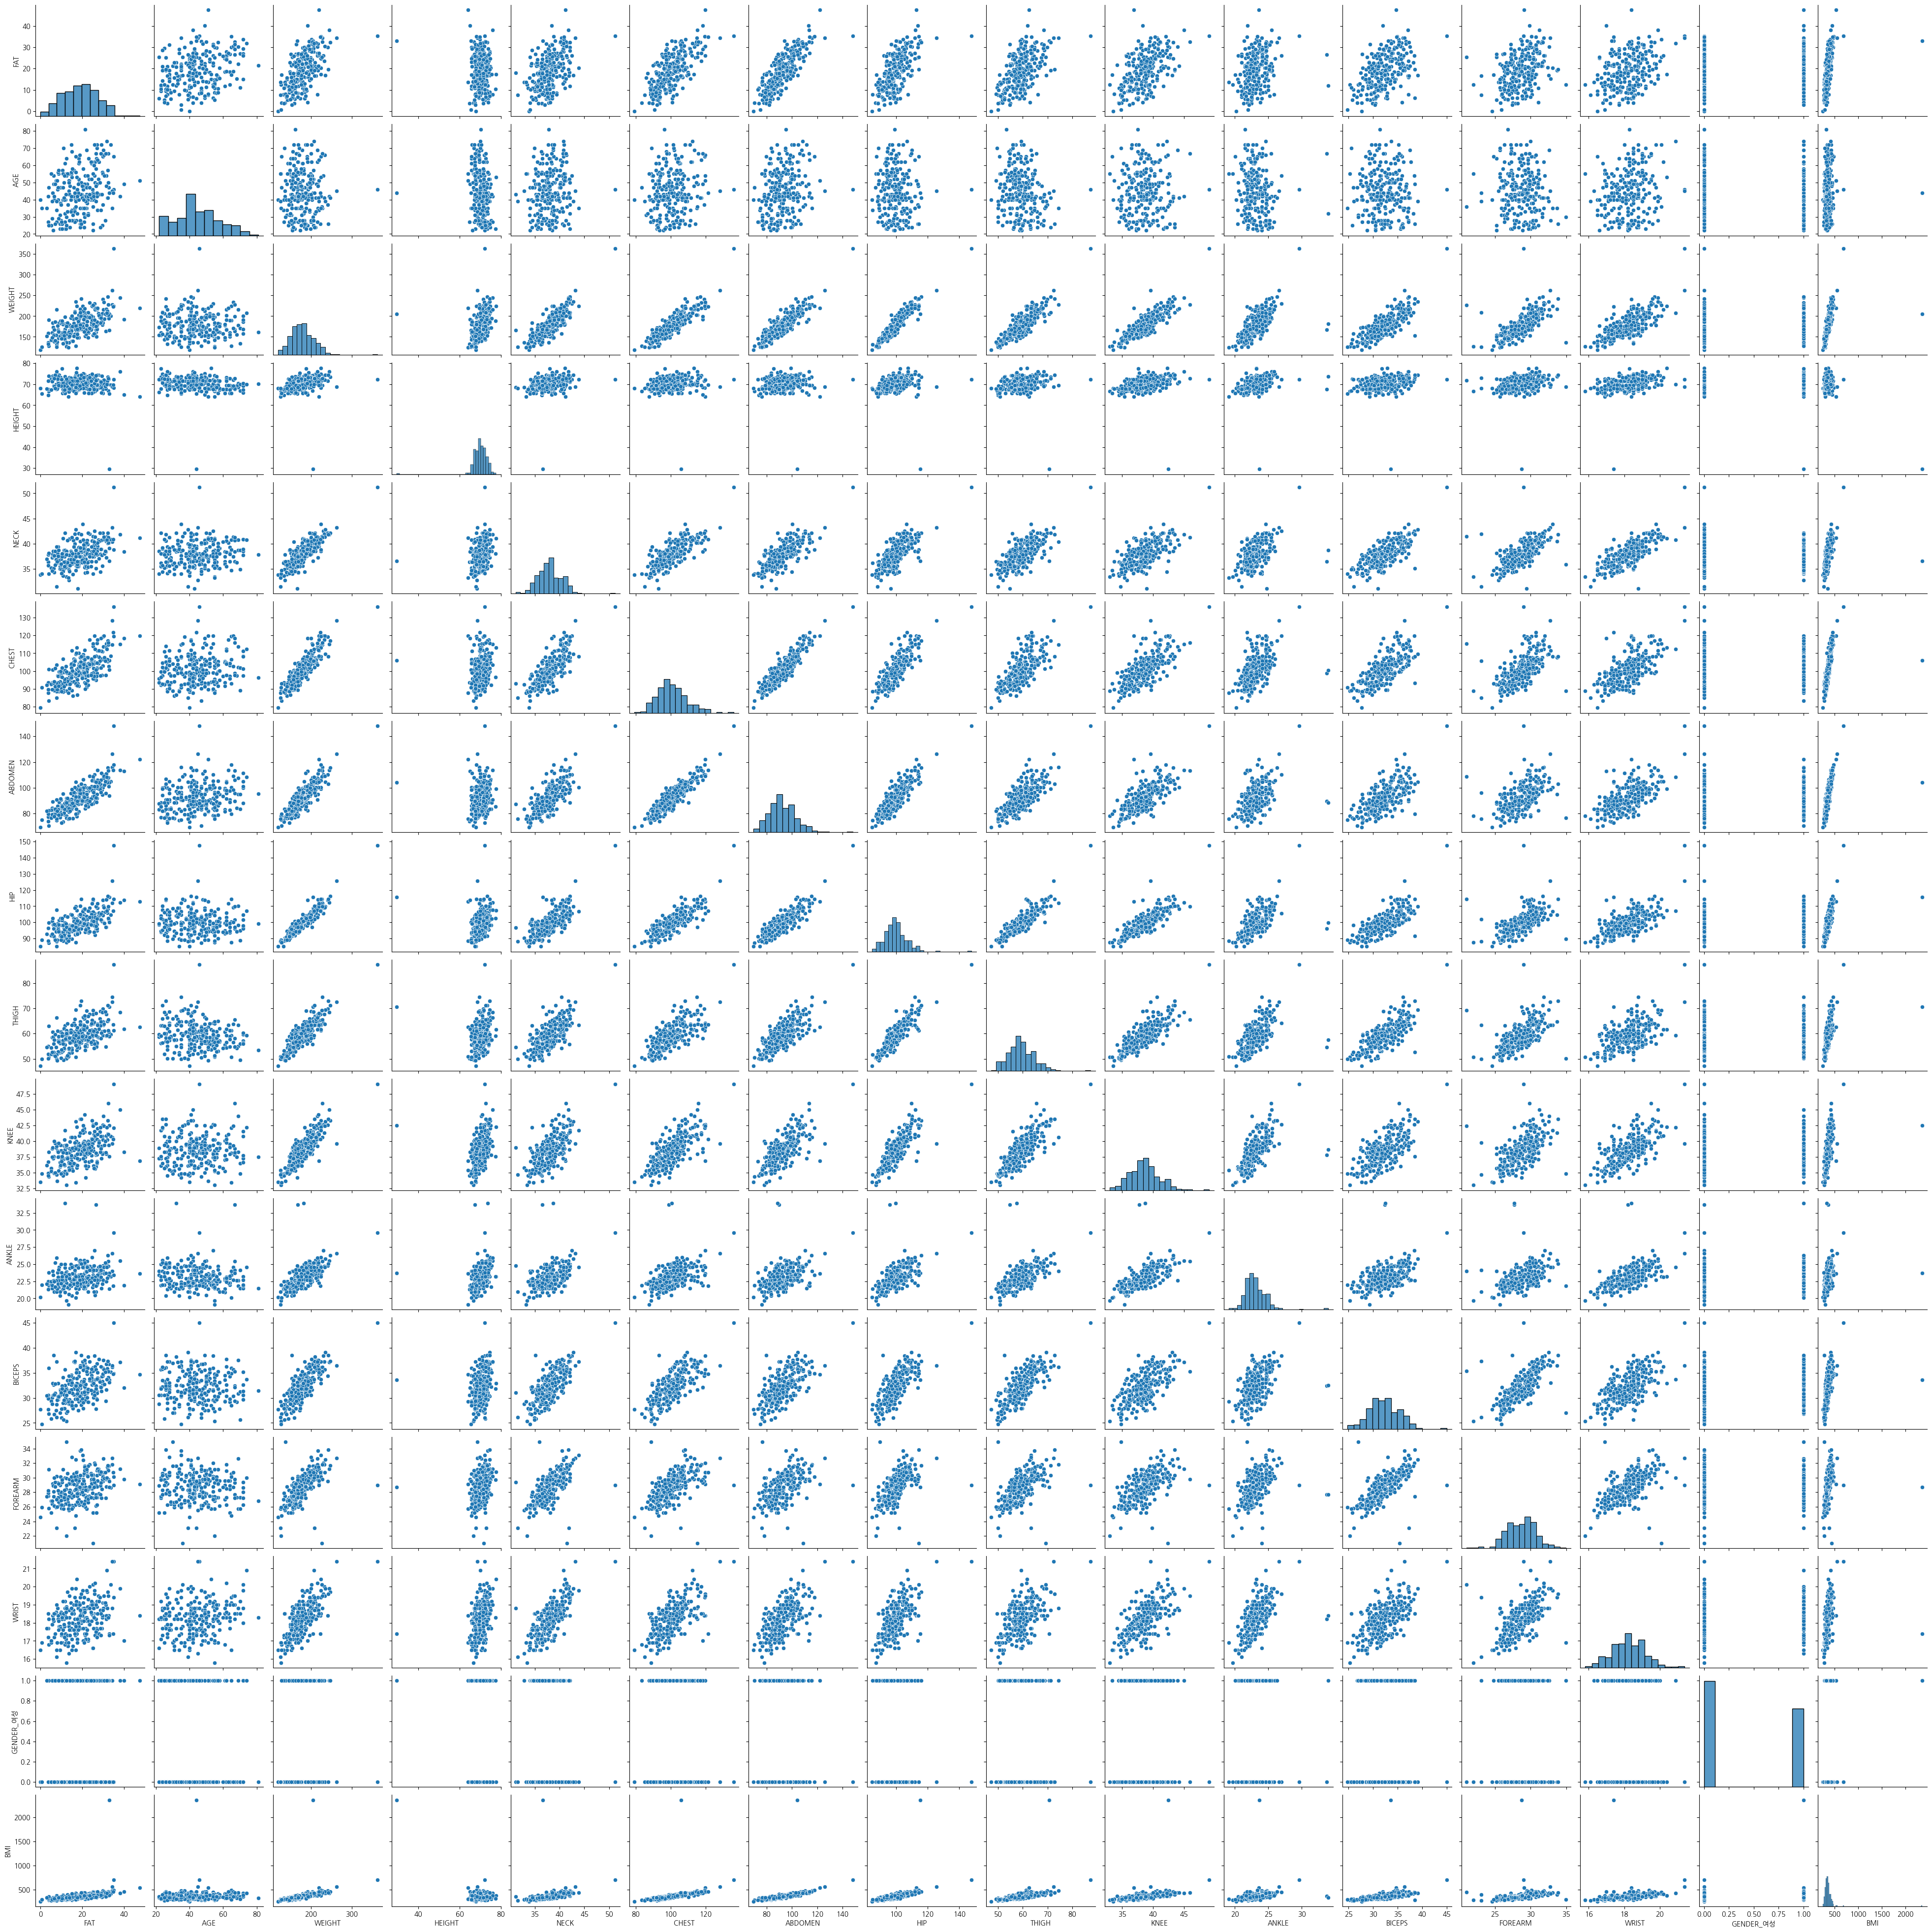

In [7]:
sns.pairplot(df_raw_dummy)

In [9]:
df_raw_dummy.corr().round(3)

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER_여성,BMI
FAT,1.000,0.291,0.612,-0.089,0.491,0.703,0.813,0.625,0.560,0.509,0.266,0.493,0.361,0.347,-0.033,0.371
AGE,0.291,1.000,-0.013,-0.172,0.114,0.176,0.230,-0.050,-0.200,0.018,-0.105,-0.041,-0.085,0.214,-0.063,0.040
WEIGHT,0.612,-0.013,1.000,0.308,0.831,0.894,0.888,0.941,0.869,0.853,0.614,0.800,0.630,0.730,-0.009,0.391
HEIGHT,-0.089,-0.172,0.308,1.000,0.254,0.135,0.088,0.170,0.148,0.286,0.265,0.208,0.229,0.322,0.025,-0.638
NECK,0.491,0.114,0.831,0.254,1.000,0.785,0.754,0.735,0.696,0.672,0.478,0.731,0.624,0.745,0.010,0.266
CHEST,0.703,0.176,0.894,0.135,0.785,1.000,0.916,0.829,0.730,0.719,0.483,0.728,0.580,0.660,-0.014,0.383
ABDOMEN,0.813,0.230,0.888,0.088,0.754,0.916,1.000,0.874,0.767,0.737,0.453,0.685,0.503,0.620,-0.017,0.415
HIP,0.625,-0.050,0.941,0.170,0.735,0.829,0.874,1.000,0.896,0.823,0.558,0.739,0.545,0.630,-0.042,0.462
THIGH,0.560,-0.200,0.869,0.148,0.696,0.730,0.767,0.896,1.000,0.799,0.540,0.761,0.567,0.559,-0.040,0.433
KNEE,0.509,0.018,0.853,0.286,0.672,0.719,0.737,0.823,0.799,1.000,0.612,0.679,0.556,0.665,-0.034,0.364


FA인(체질 비만도)와 CHEST(가슴 둘레), ABDOMEN(복부 둘레)간의 높은 선형관계 확인

In [11]:
df_train, df_test = train_test_split(df_raw_dummy, test_size=0.4, random_state=1234)
print("train dzta size : {}".format(df_train.shape))
print("test dzta size : {}".format(df_test.shape))

train dzta size : (151, 16)
test dzta size : (101, 16)


In [13]:
reg_model = smf.ols(formula='FAT ~ AGE + WEIGHT + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH +\
                             KNEE + ANKLE + BICEPS + FOREARM + WRIST + GENDER_여성 + BMI', data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     29.46
Date:                Mon, 15 May 2023   Prob (F-statistic):           2.84e-35
Time:                        15:58:49   Log-Likelihood:                -424.70
No. Observations:                 151   AIC:                             881.4
Df Residuals:                     135   BIC:                             929.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -50.8974     31.814     -1.600      0.1

No.Observaions(분석 자료 수) : 151
Df Residuals(잔차 자유도) : 135
Df Model(모델 자유도) : 15

분산분석결과
Prob : p값이 유의수준 0.05보다 작으므로 회귀모델로서 유의

설명의
Adj. R-squared = 74%

회귀계수 검정 
--> ABDOMEN, FOREARM의 P값이 유의수준 0.05보다 작으므로 유의

## 설명변수 간의 다중공선성 확인

In [14]:
df_train_x = df_train.drop('FAT',axis =1)
df_train_x_const = add_constant(df_train_x)

df_vif = pd.DataFrame()
df_vif["variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values,i)\
                for i in range(df_train_x_const.shape[1])]

df_vif.sort_values("VIF",ascending=True).round(2)



,variable,VIF
14,GENDER_여성,1.08
12,FOREARM,1.92
10,ANKLE,2.22
1,AGE,2.40
11,BICEPS,3.40
13,WRIST,3.45
4,NECK,4.67
9,KNEE,5.32
8,THIGH,9.29
15,BMI,10.55


BMI, CHEST, HEIGHT, ABDOMEN, HIP, WEIGHT 수치가 10보다 크다. 이는 다른 변수와 상관관계가 매우 높아서 
다중선성이 발생할 수 있다. 따라서 모델에서 제외를 검토해야한다. 가장 큰 WEIGHT를 먼저 제거한다.

In [15]:
reg_model = smf.ols(formula='FAT ~ AGE + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH +\
                             KNEE + ANKLE + BICEPS + FOREARM + WRIST + GENDER_여성 + BMI', data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     30.82
Date:                Mon, 15 May 2023   Prob (F-statistic):           2.38e-35
Time:                        16:02:55   Log-Likelihood:                -426.50
No. Observations:                 151   AIC:                             883.0
Df Residuals:                     136   BIC:                             928.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0157     10.981      0.275      0.7

In [17]:
df_train_x = df_train.drop(['FAT',"WEIGHT"],axis =1)
df_train_x_const = add_constant(df_train_x)

df_vif = pd.DataFrame()
df_vif["variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values,i)\
                for i in range(df_train_x_const.shape[1])]

df_vif.sort_values("VIF",ascending=True).round(2)

,variable,VIF
13,GENDER_여성,1.06
11,FOREARM,1.92
9,ANKLE,2.03
1,AGE,2.36
10,BICEPS,3.21
12,WRIST,3.43
3,NECK,3.94
8,KNEE,5.21
2,HEIGHT,6.78
14,BMI,6.88


ABDOMEN은 13.95로 다중공선성이 의심되나, 목표변수에 가장 영향이 큰 변수이므로 제거하지 않음

# 유의한 설명변수 확인

P값이 가장 큰 BICEPS 제거

In [18]:
reg_model = smf.ols(formula='FAT ~ AGE + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH +\
                             KNEE + ANKLE + FOREARM + WRIST + GENDER_여성 + BMI', data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     33.43
Date:                Mon, 15 May 2023   Prob (F-statistic):           4.09e-36
Time:                        16:04:54   Log-Likelihood:                -426.51
No. Observations:                 151   AIC:                             881.0
Df Residuals:                     137   BIC:                             923.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6828     10.779      0.249      0.8

P값이 가장 큰 GENDER_여성 제성

In [26]:
reg_model = smf.ols(formula='FAT ~ AGE + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH +\
                             KNEE + ANKLE + FOREARM + WRIST + BMI', data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     36.38
Date:                Mon, 15 May 2023   Prob (F-statistic):           7.53e-37
Time:                        16:09:22   Log-Likelihood:                -426.66
No. Observations:                 151   AIC:                             879.3
Df Residuals:                     138   BIC:                             918.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9155     10.741      0.271      0.7

P값이 가장 큰 ANKLE 제거

In [27]:
reg_model = smf.ols(formula='FAT ~ AGE + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH +\
                             KNEE + FOREARM + WRIST + BMI', data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     39.87
Date:                Mon, 15 May 2023   Prob (F-statistic):           1.34e-37
Time:                        16:09:34   Log-Likelihood:                -426.82
No. Observations:                 151   AIC:                             877.6
Df Residuals:                     139   BIC:                             913.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7005     10.706      0.252      0.8

P값이 가장 큰 KNEE 제거

In [28]:
reg_model = smf.ols(formula='FAT ~ AGE + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH +\
                             FOREARM + WRIST + BMI', data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     44.04
Date:                Mon, 15 May 2023   Prob (F-statistic):           2.27e-38
Time:                        16:09:39   Log-Likelihood:                -426.99
No. Observations:                 151   AIC:                             876.0
Df Residuals:                     140   BIC:                             909.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5136     10.578      0.332      0.7

값이 큰 CHEST 제거

In [29]:
reg_model = smf.ols(formula='FAT ~ AGE + HEIGHT + NECK + ABDOMEN + HIP + THIGH +\
                             FOREARM + WRIST + BMI', data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     49.02
Date:                Mon, 15 May 2023   Prob (F-statistic):           4.14e-39
Time:                        16:09:48   Log-Likelihood:                -427.29
No. Observations:                 151   AIC:                             874.6
Df Residuals:                     141   BIC:                             904.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8268     10.554      0.363      0.7

값이 큰 BMI 제거

In [32]:
reg_model = smf.ols(formula='FAT ~ AGE + HEIGHT + NECK + ABDOMEN + HIP + THIGH +\
                             FOREARM + WRIST', data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     55.26
Date:                Mon, 15 May 2023   Prob (F-statistic):           7.06e-40
Time:                        16:10:41   Log-Likelihood:                -427.58
No. Observations:                 151   AIC:                             873.2
Df Residuals:                     142   BIC:                             900.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2832      8.979     -0.032      0.9

값이 큰 TIGHT 제거

In [33]:
reg_model = smf.ols(formula='FAT ~ AGE + HEIGHT + NECK + ABDOMEN + HIP +\
                             FOREARM + WRIST', data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     62.88
Date:                Mon, 15 May 2023   Prob (F-statistic):           1.56e-40
Time:                        16:11:17   Log-Likelihood:                -428.23
No. Observations:                 151   AIC:                             872.5
Df Residuals:                     143   BIC:                             896.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0145      8.982      0.002      0.9

값이 큰 AGE 제거

In [34]:
reg_model = smf.ols(formula='FAT ~ HEIGHT + NECK + ABDOMEN + HIP +\
                             FOREARM + WRIST', data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     72.41
Date:                Mon, 15 May 2023   Prob (F-statistic):           5.07e-41
Time:                        16:11:41   Log-Likelihood:                -429.37
No. Observations:                 151   AIC:                             872.7
Df Residuals:                     144   BIC:                             893.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3613      8.249      0.650      0.5

값이 큰 WRIST 제거

In [35]:
reg_model = smf.ols(formula='FAT ~ HEIGHT + NECK + ABDOMEN + HIP +\
                             FOREARM', data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     85.90
Date:                Mon, 15 May 2023   Prob (F-statistic):           1.39e-41
Time:                        16:12:05   Log-Likelihood:                -430.41
No. Observations:                 151   AIC:                             872.8
Df Residuals:                     145   BIC:                             890.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7198      7.865      0.219      0.8

수정결정계수는 73.9%
p-value가 0.05보다 작은 변수만 도출

In [36]:
df_train_x = df_train[["HEIGHT","NECK","ABDOMEN","HIP","FOREARM"]]
df_train_x_const = add_constant(df_train_x)

df_vif = pd.DataFrame()
df_vif["variable"] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values,i)\
                for i in range(df_train_x_const.shape[1])]

df_vif.sort_values("VIF",inplace=True)
df_vif.round(2)

,variable,VIF
1,HEIGHT,1.14
5,FOREARM,1.46
2,NECK,2.84
4,HIP,4.63
3,ABDOMEN,4.89
0,const,512.16


다중공선성 모두 10 미만이다. 다중공선성 해결

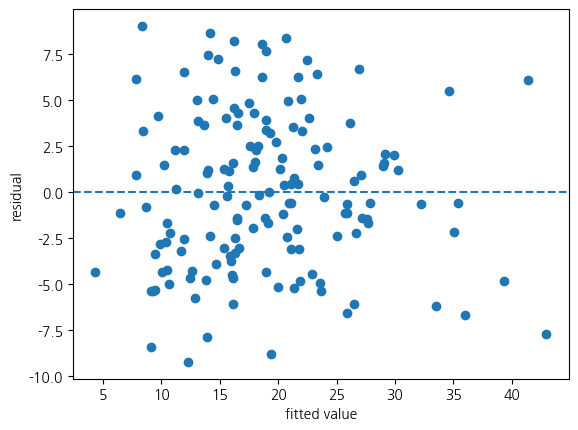

In [37]:
plt.scatter(reg_result.fittedvalues,reg_result.resid)
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.axhline(y=0,linestyle="--")

잔차가 y=0을 기준으로 Random하게 산포되어 있으므로 등분산성을 만족한다.

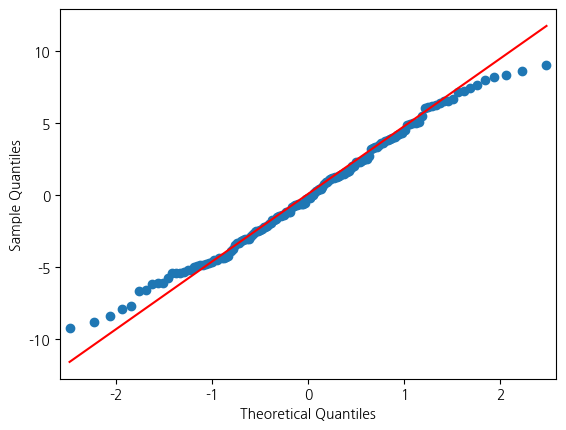

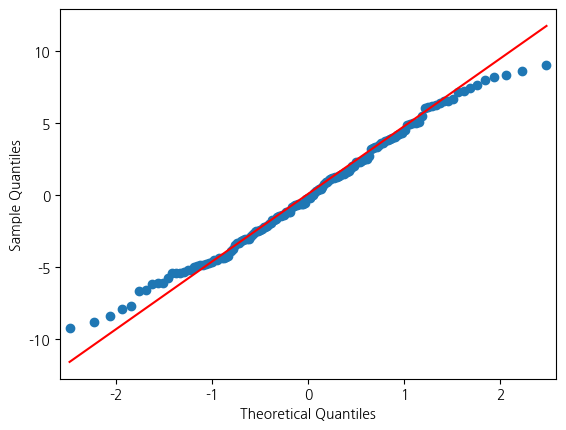

In [38]:
qqplot(reg_result.resid,line="q")

정규분포 직선(적색 선)을 중심으로 분포하므로 정규분포를 따름

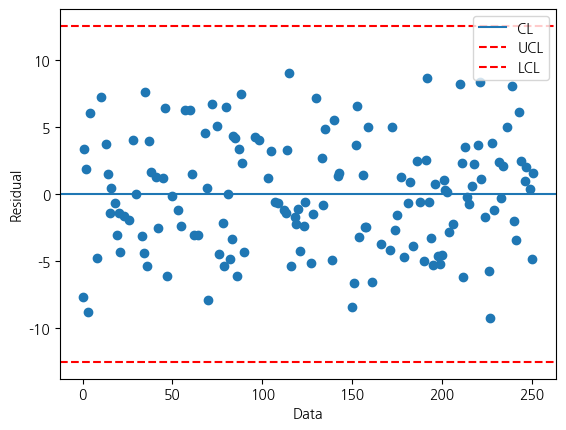

In [39]:
plt.scatter(df_train.index, reg_result.resid)
plt.xlabel("Data")
plt.ylabel("Residual")
plt.axhline(y=0,linestyle="-",label="CL")
plt.axhline(y=3*np.std(reg_result.resid),linestyle="--",color="red",label="UCL")
plt.axhline(y=-3*np.std(reg_result.resid),linestyle="dashed",color="red",label="LCL")
plt.legend()

잔차가 y=0을 기준으로 관리상하한을 벗어나지 않고, Random하게 산포되어 있으므로 독립성을 만족

In [40]:
train_pred = reg_result.predict(df_train)
test_pred = reg_result.predict(df_test)
print("train data의 결정계수: ",r2_score(df_train["FAT"],train_pred))
print("test data의 결정계수: ",r2_score(df_test["FAT"],test_pred))

train data의 결정계수:  0.7476037244115143
test data의 결정계수:  0.6911707784681436


train data의 결정계수는 74.8%, test data의 결정계수는 69.1%

In [41]:
df_train_y = df_train["FAT"]
df_train_x = df_train.drop("FAT",axis=1)

model = LinearRegression()

rfe = RFE(estimator= model, n_features_to_select=5).fit(df_train_x,df_train_y)

selected_cols = df_train_x.columns[rfe.support_]

removed_cols = df_train_x.columns[~rfe.support_]

print("Selected Variables : {}".format(selected_cols))
print("removed Variables : {}".format(removed_cols))

Selected Variables : Index(['NECK', 'ABDOMEN', 'FOREARM', 'WRIST', 'GENDER_여성'], dtype='object')
removed Variables : Index(['AGE', 'WEIGHT', 'HEIGHT', 'CHEST', 'HIP', 'THIGH', 'KNEE', 'ANKLE',
       'BICEPS', 'BMI'],
      dtype='object')


NECK, ABDOMEN, FOREARM, WRIST, GENDER_여성 선택됨

In [42]:
reg_model = smf.ols(formula='FAT ~ NECK + ABDOMEN + FOREARM + WRIST + GENDER_여성', data=df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     72.33
Date:                Mon, 15 May 2023   Prob (F-statistic):           1.17e-37
Time:                        16:19:53   Log-Likelihood:                -439.89
No. Observations:                 151   AIC:                             891.8
Df Residuals:                     145   BIC:                             909.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.7530      7.524     -1.828      0.0

No.Observaions(분석 자료 수) : 151
Df Residuals(잔차 자유도) : 145
Df Model(모델 자유도) : 5

분산분석결과
Prob : p값이 유의수준 0.05보다 작으므로 회귀모델로서 적합

설명력
Adj. R-squared = 70.4%
모델을 통하여 70.4%를 설명할 수 있음

회귀계수 검정 
--> FOREARM, WRIST는 P값이 0.05보다 크므로 유의하지 않음

#### 수작업으로 변수 선택한 내용과 다르다

<Axes: >

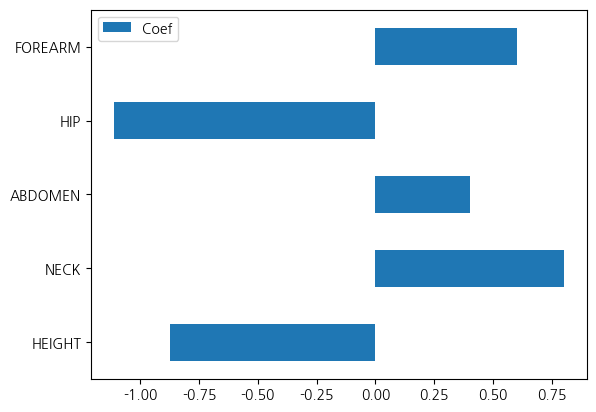

In [45]:
df_reg_coef = pd.DataFrame({"Coef": reg_result.params.values[1:]},
                          index = ["HEIGHT", "NECK", "ABDOMEN", "HIP", "FOREARM"])
df_reg_coef.plot.barh(y = "Coef")

중요도는 회귀계수의 절대값 크기
FOREARM, ABDOMEN, NECK는 커질수록 FAT이 높음
HIP, HEIGHT는 작아질수록 FAT이 높음

## 다중선형회귀분석_규제화_연습

In [82]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet


df_raw = pd.read_csv("DIABETES.csv", encoding = 'euc-kr')
df_raw_y = df_raw["Y"]
df_raw_x = df_raw.drop("Y",axis=1,inplace = False)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, 
                                                                test_size=0.3, random_state=1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test dzta X size : {}".format(df_test_x.shape))
print("test dzta Y size : {}".format(df_test_y.shape))


train data X size : (309, 10)
train data Y size : (309,)
test dzta X size : (133, 10)
test dzta Y size : (133,)
